## 包的导入

In [1]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import tensorflow as tf

from tensorflow import keras
import os, sys, time 


print(sys.version_info)
for module in tf, mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)



sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
tensorflow 2.1.0
matplotlib 3.2.0
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2.post1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


## TF data模块处理数据

In [2]:
dataset = tf.data.Dataset.from_tensor_slices(np.arange(10,dtype=np.float32))
print(dataset)
for _ in dataset:
    print(_)

<TensorSliceDataset shapes: (), types: tf.float32>
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(5.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(7.0, shape=(), dtype=float32)
tf.Tensor(8.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)


In [3]:
'''
数据操作：
'''
# repeat epoch+get batch
dataset = dataset.repeat(3).batch(7)
for _ in dataset:
    print(_)


tf.Tensor([0. 1. 2. 3. 4. 5. 6.], shape=(7,), dtype=float32)
tf.Tensor([7. 8. 9. 0. 1. 2. 3.], shape=(7,), dtype=float32)
tf.Tensor([4. 5. 6. 7. 8. 9. 0.], shape=(7,), dtype=float32)
tf.Tensor([1. 2. 3. 4. 5. 6. 7.], shape=(7,), dtype=float32)
tf.Tensor([8. 9.], shape=(2,), dtype=float32)


In [4]:
# interleave
# case ：文件dataset -> 具体数据集
dataset2 = dataset.interleave(
    # map_fn
    lambda x: tf.data.Dataset.from_tensor_slices(x),
    # cycle_length
    cycle_length = 5,
    # block_length
    block_length = 5,
)
for _ in dataset2:
    print(_)

tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(7.0, shape=(), dtype=float32)
tf.Tensor(8.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(0.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(5.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(7.0, shape=(), dtype=float32)
tf.Tensor(8.0, shape=(), dtype=float32)
tf.Tensor(1.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)
tf.Tensor(3.0, shape=(), dtype=float32)
tf.Tensor(4.0, shape=(), dtype=float32)
tf.Tensor(5.0, shape=(), dtype=float32)
tf.Tensor(8.0, shape=(), dtype=float32)
tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(5.0, shape=(), dtype=float32)
tf.Tensor(6.0, shape=(), dtype=float32)
tf.Tensor(2.0, shape=(), dtype=float32)


In [5]:
# tfrecord 文件格式
# -> tf.train.Example
# -> tf.train.Feature -> {'key':tf.train.Feature}
# -> tf.train.Feature - >tf.train.ByteList/FloatList/Int64List
favorite_books = [name.encode('utf-8') for name in ['machine learning', 'cc150']]
favorite_books_bytelist = tf.train.BytesList(value=favorite_books)
print(favorite_books_bytelist)

hours_floatlist = tf.train.FloatList(value=[15.5, 9.5, 7.0, 8.0])
print(hours_floatlist)

age_int64list = tf.train.Int64List(value=[42])
print(age_int64list)

features = tf.train.Features(
    feature = {
        'favorite_book': tf.train.Feature(bytes_list = favorite_books_bytelist),
        'hours': tf.train.Feature(float_list = hours_floatlist),
        'age': tf.train.Feature(int64_list = age_int64list),
    }
)
print(features)

value: "machine learning"
value: "cc150"

value: 15.5
value: 9.5
value: 7.0
value: 8.0

value: 42

feature {
  key: "age"
  value {
    int64_list {
      value: 42
    }
  }
}
feature {
  key: "favorite_book"
  value {
    bytes_list {
      value: "machine learning"
      value: "cc150"
    }
  }
}
feature {
  key: "hours"
  value {
    float_list {
      value: 15.5
      value: 9.5
      value: 7.0
      value: 8.0
    }
  }
}



## TF 骚操作
将自己写的function转化成tf.function
优势：快

In [6]:
# tf.function and auto-graph
def scaled_elu(z, scale=1.0, alpha=1.0):
    # z>=0? scale * z : scale:alpha * tf.nn.eu(z)
    is_postive = tf.greater_equal(z, 0.0)
    return scale * tf.where(is_postive, z, alpha * tf.nn.elu(z))
print(scaled_elu(tf.constant(-1.)))
print(scaled_elu(tf.constant([-3., -2.5])))
# 用tf.function 将函数转化为tf函数
# 方式1
tf_scale = tf.function(scaled_elu)
print(tf_scale(tf.constant(-1.)))
print(tf_scale(tf.constant([-3., -2.5])))
# 方式2
@tf.function
def tf_scale2(z, scale=1.0, alpha=1.0):
    # z>=0? scale * z : scale:alpha * tf.nn.eu(z)
    is_postive = tf.greater_equal(z, 0.0)
    return scale * tf.where(is_postive, z, alpha * tf.nn.elu(z))
print(tf_scale2(tf.constant(-1.)))
print(tf_scale2(tf.constant([-3., -2.5])))

# 将展转化后的函数展示出来
def display_tf_code(func):
    code = tf.autograph.to_code(func)
    from IPython.display import display, Markdown
    display(Markdown('```python\n{}\n```'.format(code)))
# 展示源码
display_tf_code(scaled_elu)

tf.Tensor(-0.63212055, shape=(), dtype=float32)
tf.Tensor([-0.95021296 -0.917915  ], shape=(2,), dtype=float32)
tf.Tensor(-0.63212055, shape=(), dtype=float32)
tf.Tensor([-0.95021296 -0.917915  ], shape=(2,), dtype=float32)
tf.Tensor(-0.63212055, shape=(), dtype=float32)
tf.Tensor([-0.95021296 -0.917915  ], shape=(2,), dtype=float32)


```python
def tf__scaled_elu(z, scale=None, alpha=None):
  do_return = False
  retval_ = ag__.UndefinedReturnValue()
  with ag__.FunctionScope('scaled_elu', 'fscope', ag__.ConversionOptions(recursive=True, user_requested=True, optional_features=(), internal_convert_user_code=True)) as fscope:
    is_postive = ag__.converted_call(tf.greater_equal, (z, 0.0), None, fscope)
    do_return = True
    retval_ = fscope.mark_return_value(scale * ag__.converted_call(tf.where, (is_postive, z, alpha * ag__.converted_call(tf.nn.elu, (z,), None, fscope)), None, fscope))
  do_return,
  return ag__.retval(retval_)

```

In [7]:
var = tf.Variable(0.)

@tf.function
def add_21():
    return var.assign_add(21)
print(add_21())

# 如果将var放在函数里面?,会报错!所以在我们定义使用function之前我们需要将var = tf.Variable(0.)定义在函数初始化之前
@tf.function
def add_21():
    var = tf.Variable(0.)
    return var.assign_add(21)
# print(add_21()) 打印会报错


tf.Tensor(21.0, shape=(), dtype=float32)


In [8]:
@tf.function()
def cube(z):
    return tf.pow(z,3)
# 我们输入的数据类型不一样 输出的类型也不一样
print(cube(tf.constant([1.,2.,3.])))
print(cube(tf.constant([1,2,3])))



tf.Tensor([ 1.  8. 27.], shape=(3,), dtype=float32)
tf.Tensor([ 1  8 27], shape=(3,), dtype=int32)


In [9]:
# 我们给函数加上一个变量限制
@tf.function(input_signature=[tf.TensorSpec([None], tf.int32, name='x')])
def cube(z):
    return tf.pow(z,3)
try:
    print(cube(tf.constant([1.,2.,3.])))
    print(cube(tf.constant([1,2,3])))
except ValueError as e:
    print(e)

Python inputs incompatible with input_signature:
  inputs: (
    tf.Tensor([1. 2. 3.], shape=(3,), dtype=float32))
  input_signature: (
    TensorSpec(shape=(None,), dtype=tf.int32, name='x'))


In [10]:
cube_func_int32 = cube.get_concrete_function(tf.TensorSpec([None],tf.int32, name='x'))
print(cube_func_int32)
print(cube_func_int32 is cube.get_concrete_function(tf.TensorSpec([5], tf.int32, name='x')))
print(cube_func_int32 is cube.get_concrete_function(tf.constant([1,2,3])))
print(cube_func_int32.graph)
print(cube_func_int32.graph.get_operations())

True
True
FuncGraph(name=cube, id=2325995326824)
[<tf.Operation 'x' type=Placeholder>, <tf.Operation 'Pow/y' type=Const>, <tf.Operation 'Pow' type=Pow>, <tf.Operation 'Identity' type=Identity>]


In [11]:
pow_op =  cube_func_int32.graph.get_operations()[2]
# 打印操作的过程
print(pow_op)
# 其中的值都是可以取出来的
print(pow_op.name)
print(list(pow_op.inputs))
print(list(pow_op.outputs))

name: "Pow"
op: "Pow"
input: "x"
input: "Pow/y"
attr {
  key: "T"
  value {
    type: DT_INT32
  }
}

Pow
[<tf.Tensor 'x:0' shape=(None,) dtype=int32>, <tf.Tensor 'Pow/y:0' shape=() dtype=int32>]
[<tf.Tensor 'Pow:0' shape=(None,) dtype=int32>]


In [12]:
# 求近似导数
f = lambda x:3. *x **2 +2.*x-1
approximate_derivative = lambda f, x, eps=1e-4 : (f(x+eps) - f(x-eps))/(2. * eps)
print(approximate_derivative(f,1.))

g = lambda x1,x2:(x1+5)*(x2**2)
def approximate_gradient(g, x1, x2, eps=1e-3):
    dg_x1 = approximate_derivative(lambda x:g(x,x2),x1,eps)
    dg_x2 = approximate_derivative(lambda x:g(x2,x),x2,eps)
    return dg_x1,dg_x2
print(approximate_gradient(g,2.,3.))


7.999999999994678
(8.999999999993236, 47.999999999994714)


In [13]:
x1 = tf.Variable(2.0)
x2 = tf.Variable(3.0)
with tf.GradientTape() as tape:
    z = g(x1,x2)
# 对z函数求x1的偏导
# tape只能调用一次
dz_x1 = tape.gradient(z,x1)
print(dz_x1)

try:
    dz_x2 = tape.gradient(z,x2)
except RuntimeError as e:
    print(e)

tf.Tensor(9.0, shape=(), dtype=float32)
GradientTape.gradient can only be called once on non-persistent tapes.


In [14]:
# 我们加上persistent后就可以求两次偏导了，结果为9和42，和上面的结果误差比较大
with tf.GradientTape(persistent = True) as tape:
    z = g(x1,x2)

dz_x1 = tape.gradient(z,x1)
print(dz_x1)

try:
    dz_x2 = tape.gradient(z,x2)
    print(dz_x2)
except RuntimeError as e:
    print(e)
del(tape)

tf.Tensor(9.0, shape=(), dtype=float32)
tf.Tensor(42.0, shape=(), dtype=float32)


In [15]:
# 一次性求出两个偏导
with tf.GradientTape() as tape:
    z = g(x1,x2)

dz = tape.gradient(z,[x1,x2])
print(dz)


[<tf.Tensor: shape=(), dtype=float32, numpy=9.0>, <tf.Tensor: shape=(), dtype=float32, numpy=42.0>]


In [16]:

x1 = tf.constant(2.0)
x2 = tf.constant(3.0)

with tf.GradientTape() as tape:
    tape.watch(x1)
    tape.watch(x2)
    z = g(x1,x2)
print(tape.gradient(z, [x1,x2]))

[<tf.Tensor: shape=(), dtype=float32, numpy=9.0>, <tf.Tensor: shape=(), dtype=float32, numpy=42.0>]


In [17]:
x = tf.Variable(5.)
with tf.GradientTape() as tape:
    z1 = 3*x
    z2 = x**2
tape.gradient([z1,z2],x)

<tf.Tensor: shape=(), dtype=float32, numpy=13.0>

In [18]:
# 模拟一次梯度下降
f = lambda x:3. *x **2 +2.*x-1
learning_rate = 0.1
x = tf.Variable(0.0)
print(x)
for _ in range(100):
    with tf.GradientTape() as tape:
        z = f(x)
    dz_dx = tape.gradient(z,x)
    # x.assign_sub(learning_rate*dz_dx) 表示x= x-(learning_rate*dz_dx)
    x.assign_sub(learning_rate*dz_dx)
    # print(x)
print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.3333333>


In [20]:
# 模拟一次梯度下降
f = lambda x:3. *x **2 +2.*x-1
learning_rate = 0.1
x = tf.Variable(0.0)
optimizer = keras.optimizers.SGD(lr = learning_rate)
print(x)
for _ in range(100):
    with tf.GradientTape() as tape:
        z = f(x)
    dz_dx = tape.gradient(z,x)
    optimizer.apply_gradients([(dz_dx,x)])
    # print(x)
    # x.assign_sub(learning_rate*dz_dx) 表示x= x-(learning_rate*dz_dx)
print(x)

<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=0.0>
<tf.Variable 'Variable:0' shape=() dtype=float32, numpy=-0.3333333>


## 数据集的准备
Fashion-MNIST是一个替代MNIST手写数字集的图像数据集。 它是由Zalando（一家德国的时尚科技公司）旗下的研究部门提供。其涵盖了来自10种类别的共7万个不同商品的正面图片。Fashion-MNIST的大小、格式和训练集/测试集划分与原始的MNIST完全一致。60000/10000的训练测试数据划分，28x28的灰度图片。你可以直接用它来测试你的机器学习和深度学习算法性能，且不需要改动任何的代码。
- 60000张训练图像和对应Label；
- 10000张测试图像和对应Label；
- 10个类别；
- 每张图像28x28的分辨率；

In [19]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
# fashion_mnist 训练集共有60000，将前5000作为验证集，后55000作为训练集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print("x_valid.shape, y_valid.shape:",x_valid.shape, y_valid.shape)
print("x_train.shape, y_train.shape",x_train.shape, y_train.shape)
print("x_test.shape, y_test.shape",x_test.shape, y_test.shape)

x_valid.shape, y_valid.shape: (5000, 28, 28) (5000,)
x_train.shape, y_train.shape (55000, 28, 28) (55000,)
x_test.shape, y_test.shape (10000, 28, 28) (10000,)


## 数据集样本展示

In [21]:
# 数据集样本展示
def show_single_img(img_arr):
    plt.imshow(img_arr, cmap="binary")
    plt.show()
# show_single_img(x_train[0])

## 对数据进行归一化处理
> 定义：把数据经过处理后使之限定在一定的范围内。比如通常限制在区间`[0, 1]`或者`[-1, 1]`

常用归一化法：
- 最大-最小标准化: $$\frac{x-x_{min}}{x_{max}-x_{min}}$$
- Z-score标准化: $$\frac{x-\mu }{std} \left ( \mu为标准差 ,std 为方差 \right ) $$

In [22]:
'''
对数据进行归一化处理
定义：把数据经过处理后使之限定在一定的范围内。比如通常限制在区间[0, 1]或者[-1, 1]
Z-score归一化
'''
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# x_train:[None, 28, 28] -> [None, 784]
# 我们np里的数据是int类型，所以我们需要x_train.astype(np.float32)将数据转化成float32
# fit_transform 不仅有数据转化为归一化的功能，还有fit（将数据存储下来）的功能.
Z_score = lambda d:scaler.fit_transform(d.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
x_train_scaled = Z_score(x_train)
x_valid_scaled = Z_score(x_valid)
x_test_scaled = Z_score(x_test)

In [23]:
metric = keras.metrics.MeanSquaredError()
print(metric([5.],[2.,1],))
metric.reset_states
print(metric([0.],[1.]))

print(metric.result())

tf.Tensor(12.5, shape=(), dtype=float32)
tf.Tensor(6.75, shape=(), dtype=float32)
tf.Tensor(6.75, shape=(), dtype=float32)


batch : 遍历训练集metric
- 自动求导
epoch结束:验证集 metric

In [33]:
epochs = 10
batch_size = 32
steps_per_epoch = len(x_train_scaled) // batch_size
print(steps_per_epoch)
optimizer = keras.optimizers.SGD()

def random_batch(x,y,batch_size=32):
    idx = np.random.randint(0, len(x), size=batch_size)
    return x[idx], y[idx]

model = keras.models.Sequential([
    keras.layers.Dense(30, activation = 'relu', input_shape=x_train.shape[1:]),
    keras.layers.Dense(1),
])

metric = keras.metrics.MeanSquaredError()
for epoch in range(epochs):
    metric.reset_states()
    for step in range(steps_per_epoch):
        x_batch, y_batch = random_batch(x_train_scaled, y_train, batch_size)
        
        with tf.GradientTape() as tape:
            y_pred = model(x_batch)
            loss = tf.reduce_mean(keras.losses.mean_squared_error(y_batch, y_pred))
            metric(y_batch, y_pred)
        grads = tape.gradient(loss, model.variables)
        grads_and_vars = zip(grads, model.variables)
        optimizer.apply_gradients(grads_and_vars)
        print('\rEpoch', epoch, 'train mse:',metric.result().numpy(), end='')
        
    y_valid_pred = model(x_valid_scaled)
    # 将数据转化成float32格式，不然会报错
    y_valid = tf.dtypes.cast(y_valid,tf.float32)
    valid_loss = tf.reduce_mean(keras.losses.mean_squared_error(y_valid_pred, y_valid))
    print('\t', 'valid mse:', valid_loss.numpy())


1718
Epoch 0 train mse: 8.444045	 valid mse: 8.318773
Epoch 1 train mse: 8.288684	 valid mse: 8.272807
Epoch 2 train mse: 8.279286	 valid mse: 8.326979
Epoch 3 train mse: 8.27741	 valid mse: 8.239223
Epoch 4 train mse: 8.273457	 valid mse: 8.242294
Epoch 5 train mse: 8.217403	 valid mse: 8.25629
Epoch 6 train mse: 8.296442	 valid mse: 8.23847
Epoch 7 train mse: 8.26509	 valid mse: 8.238471
Epoch 8 train mse: 8.295274	 valid mse: 8.272746
Epoch 9 train mse: 8.289257	 valid mse: 8.2716055


## 模型的构建
tf.keras.models.sequential()
普通的模型构建：
```
model = keras.models.Sequential([
    # 第一层输入成，每一个组数据为[28,28]的二维矩阵，通过keras.layers.Flatten压缩成一维矩阵
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation = "relu"),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(10, activation = "softmax"),
])
```
批归一化加激活函数模型构建：

```
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    model.add(keras.layers.Dense(100,activation='relu'))
    # 批归一化
    model.add(keras.layers.BatchNormalization())
    '''
    model.add(keras.layers.Dense(100))
    # 将批归一化放在激活函数之前
    model.add(keras.layers.BatchNormalization())
    # 我们还可以将激活函数设置为一个层次
    model.add(keras.layers.Activation('selu'))
    model.add(keras.layers.Dense(10,activation='softmax'))
    '''
```

添加dropout层，一般情况下我们只在最后几层添加dropout：

```
# deep_neural_network模型的构建(20层)
model.add(keras.layers.Flatten(input_shape=[28,28]))
for _ in range(20):
    # 其中selu是一个自带归一化的激活函数,会在
    model.add(keras.layers.Dense(100,activation='selu'))
# AlphaDropout相比 强大在：1，均值和方差不变 2.归一化的性质不变，分布不会发生变化，可以和批归一化一起使用
model.add(keras.layers.AlphaDropout(rate=0.5,))
# model.add(keras.layers.Dropout(rate=0.5))
model.add(keras.layers.Dense(10,activation='softmax'))
```
wide&deep模型的构建：
```
# 使用API实现wide&deep模型
class WideDeepModel(keras.models.Model):
    def __init__(self):
        super(WideDeepModel, self).__init__()
        '''定义模型的层次'''
        self.hidden1_layer = keras.layers.Dense(30, activation='relu')
        self.hidden2_layer = keras.layers.Dense(30, activation='relu')
        self.output_layer = keras.layers.Dense(1)
        

    def call(self, input):
        '''完成模型的正向计算'''
        hidden1 = self.hidden1_layer(input)
        hidden2 = self.hidden2_layer(input)
        concat = keras.layers.concatenate([input, hidden2])
        output = self.output_layer(concat)
        return output
# wd模型的建立方式1,这样可以展示更多的细节
'''
# none 是样本数目，8对应的是features的数目
Model: "wide_deep_model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
dense_42 (Dense)             multiple                  270       
_________________________________________________________________
dense_43 (Dense)             multiple                  270       
_________________________________________________________________
dense_44 (Dense)             multiple                  39        
=================================================================
'''
model = WideDeepModel()
# wd模型的建立方式2
# model = keras.models.Sequential([
#     WideDeepModel(),
# ])

'''
# none 是样本数目，8对应的是features的数目
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
=================================================================
wide_deep_model_13 (WideDeep multiple                  579       
=================================================================
'''
model.build(input_shape=(None, 8))
```
对于多输入的wide&deep模型的构建：
```
# 前五个feature当作wide模型的输入
input_wide = keras.layers.Input(shape=[5])
# 后六个feature当作deep模型的输入
input_deep = keras.layers.Input(shape=[6])
# deep_model有两个隐含层
hidden1 = keras.layers.Dense(30,activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30,activation='relu')(hidden1)
# 将构建的deep层和wide给拼接起来
concat = keras.layers.concatenate([input_wide, hidden2])
# 定义输出层
output = keras.layers.Dense(1)
# 模型定义完成
model = keras.model.Model(inputs=[input_wide, input_deep], outputs=[output]))
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# 对于deep&and模型多输入的时候，我们的的训练数据也需要进行拆分
x_train_scaled_wide = x_train_scaled[:,:5]
x_train_scaled_deep = x_train_scaled[:,2:]
x_valid_scaled_wide = x_valid_scaled[:,:5]
x_valid_scaled_deep = x_valid_scaled[:,2:]
x_test_scaled_wide = x_test_scaled[:,:5]
x_test_scaled_deep = x_test_scaled[:,2:]
# 数据的训练
history = model.fit([x_train_scaled_wide,x_train_scaled_deep], 
                        y_train,
                        epochs=10,
                        validation_data=([x_valid_scaled_wide,x_valid_scaled_deep],y_valid))
# mdhistory.history
```
对于多输入多输出的wide&deep模型的构建：
```
# 前五个feature当作wide模型的输入
input_wide = keras.layers.Input(shape=[5])
# 后六个feature当作deep模型的输入
input_deep = keras.layers.Input(shape=[6])
# deep_model有两个隐含层
hidden1 = keras.layers.Dense(30,activation='relu')(input_deep)
hidden2 = keras.layers.Dense(30,activation='relu')(hidden1)
# 将构建的deep层和wide给拼接起来
concat = keras.layers.concatenate([input_wide, hidden2])
# 定义输出层
output = keras.layers.Dense(1)(concat)
# 在hidden2层后我们定义一次输出
output2 = keras.layers.Dense(1)(hidden2)
# 模型定义完成
model = keras.models.Model(inputs=[input_wide, input_deep], 
                            outputs=[output,output2])

# reason for sparse : y->index, y->one_hot->[],我们需要将y处理成one_hot向量所以用sparse
model.compile(loss="sparse_categorical_crossentropy",optimizer='sgd', metrics= ['accuracy'])
# 定义的模型中的所有层
model.layers
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
# 对于deep&and模型我们的的训练数据也需要进行拆分
x_train_scaled_wide = x_train_scaled[:,:5]
x_train_scaled_deep = x_train_scaled[:,2:]
x_valid_scaled_wide = x_valid_scaled[:,:5]
x_valid_scaled_deep = x_valid_scaled[:,2:]
x_test_scaled_wide = x_test_scaled[:,:5]
x_test_scaled_deep = x_test_scaled[:,2:]
# 数据的训练, 当有多个输出的时候，我们的y_train也需要定义两份
history = model.fit([x_train_scaled_wide,x_train_scaled_deep], 
                        [y_train,y_train],
                        epochs=10,
                        validation_data=([x_valid_scaled_wide,x_valid_scaled_deep],[y_valid,y_valid]))
# mdhistory.history
```
超参：
神经网络有很多训练过程中不变的参数
- 网络结构参数：几层，每层宽度，每层激活函数等
- 训练参数：batch_size，学习率，学习率衰减算法等
手工去试的话比较耗费人力
超参搜索策略：
- 网络搜索
- 随机搜索
- 遗传算法搜索
- 启发式搜索
使用sklearn封装keras模型：
```
'''
RandomizedSearchCV
转化为skleran的model
定义参数集合
搜索参数
'''
def build_model(hidden_layers = 1,
                            layer_size = 30,
                            learning_rate = 3e-3):
    model = keras.models.Sequential()
    model.add(keras.layers.Dense(layer_size, activation='relu',inpute_shape=x_train.shape[1:]))
    for _ in range(hidden_layers - 1):
        model.add(keras.layers.Dense(layer_size,activation = 'relu'))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(leraning_rate)
    mode.compile(loss='mse',optimizer=optimizer)
    return model
skleran_model = keras.wrappers.scikit_learn.KerasRegressor(build_model)
sklearn_model.fit(x_train_scaled, y_train, epochs = 100, validation_data = (x_valid_scaled,y_valid))
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu'),
    keras.layers.Dense(1),
])
```
自定义层的两种方式
```
# 自定义层的两种方式
Customized_softplus = keras.layers.Lambda(lambda x:tf.nn.softplus(x))

class CustomizedDenseLayer(keras.layers.Layer):
    def __init__(self, units, activation=None, **kwargs):
        # 层次的输出：units
        self.units = units
        self.activation = keras.layers.Activation(activation)
        super(CustomizedDenseLayer, self).__init__(**kwargs)
    def build(self, input_shape):
        '''构建所需要的参数'''
        # x*w+b input_shape:[none,a], w;[a,b],output_shape:[none,b]
        self.kernel = self.add_weight(name='kernel', shape=(input_shape[1],self.units),initializer='uniform',trainable=True)
        self.bias = self.add_weight(name='bias', shape=(self.units,),initializer='zeros',trainable=True)
        super(CustomizedDenseLayer, self).build(input_shape)
    def call(self,x):
        '''完整计算向量'''
        return self.activation(x @ self.kernel + self.bias)
model = keras.models.Sequential([
    CustomizedDenseLayer(30, activation='relu'),
    CustomizedDenseLayer(1),
    # Customized_softplus 和 keras.layers.Dense(1,activation='softplus')是等价的
    Customized_softplus,
])
```

In [80]:
# 模型的构建
# tf.keras.models.sequential()
# 将 28*28 的矩阵展开为一维向量
print('训练集中第0个数据：',x_train[0].shape)
model = keras.models.Sequential([
    # 第一层输入成，每一个组数据为[28,28]的二维矩阵，通过keras.layers.Flatten压缩成一维矩阵
    keras.layers.Flatten(input_shape=[28,28]),
    keras.layers.Dense(300, activation = "relu"),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(10, activation = "softmax"),
])
model.compile(loss="sparse_categorical_crossentropy",optimizer='sgd', metrics= ['accuracy'])
# 定义的模型中的所有层
model.summary()

训练集中第0个数据： (28, 28)
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_39 (Dense)             (None, 300)               235500    
_________________________________________________________________
dense_40 (Dense)             (None, 100)               30100     
_________________________________________________________________
dense_41 (Dense)             (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


## 超参数


In [74]:
# 对于deep&wide模型我们的的训练数据也需要进行拆分---------是哦那个deep&wide模型得时候使用
x_train_scaled_wide = x_train_scaled[:,:5]
x_train_scaled_deep = x_train_scaled[:,2:]
x_valid_scaled_wide = x_valid_scaled[:,:5]
x_valid_scaled_deep = x_valid_scaled[:,2:]
x_test_scaled_wide = x_test_scaled[:,:5]
x_test_scaled_deep = x_test_scaled[:,2:]
# 数据的训练, 当有多个输出的时候，我们的y_train也需要定义两份
mdhistory = model.fit([x_train_scaled_wide,x_train_scaled_deep], 
                        [y_train,y_train],
                        epochs=10,
                        validation_data=([x_valid_scaled_wide,x_valid_scaled_deep],[y_valid,y_valid]))
mdhistory.history

## 数据的训练
### [添加回调函数pg](https://tensorflow.google.cn/api_docs/python/tf/keras/callbacks?hl=zh_cn)
- Tensorboard: 
    - Metrics summary plots 指标摘要图
    - Training graph visualization 训练图可视化
    - Activation histograms 激活直方图
    - Sampled profiling 采样分析
- EarlyStopping 
    - 关注某个指标，比如超参
        超参数之一是定型周期（epoch）的数量：亦即应当完整遍历数据集多少次（一次为一个epoch）？如果epoch数量太少，网络有可能发生欠拟合（即对于定型数据的学习不够充分）；如果epoch数量太多，则有可能发生过拟合（即网络对定型数据中的“噪声”而非信号拟合）。

    早停法旨在解决epoch数量需要手动设置的问题。它也可以被视为一种能够避免网络发生过拟合的正则化方法（与L1/L2权重衰减和丢弃法类似）。

    根本原因就是因为继续训练会导致测试集上的准确率下降。
    那继续训练导致测试准确率下降的原因猜测可能是1. 过拟合 2. 学习率过大导致不收敛

### 对layers进行数据训练

In [81]:
logdir = os.path.join('callbacks')

if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")
callbacks = [
    keras.callbacks.TensorBoard(logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only = True),
    # 由于epochs设置的比较小，可能不会触发，可以将epochs调大点，看看EarlyStopping的运行情况
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]

# 数据的训练
history = model.fit(x_train, y_train, epochs=10,validation_data=(x_valid,y_valid))
history.history

Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 5s 93us/sample - loss: inf - accuracy: 0.0982 - val_loss: 2.3041 - val_accuracy: 0.0984
Epoch 2/10
55000/55000 [==============================] - 5s 96us/sample - loss: 2.3027 - accuracy: 0.0982 - val_loss: 2.3040 - val_accuracy: 0.0986
Epoch 3/10
55000/55000 [==============================] - 5s 86us/sample - loss: 2.3027 - accuracy: 0.1006 - val_loss: 2.3041 - val_accuracy: 0.0986
Epoch 4/10
55000/55000 [==============================] - 4s 81us/sample - loss: 2.3027 - accuracy: 0.0987 - val_loss: 2.3042 - val_accuracy: 0.0914
Epoch 5/10
55000/55000 [==============================] - 7s 121us/sample - loss: 2.3027 - accuracy: 0.0984 - val_loss: 2.3040 - val_accuracy: 0.0980
Epoch 6/10
55000/55000 [==============================] - 11s 194us/sample - loss: 2.3027 - accuracy: 0.0972 - val_loss: 2.3039 - val_accuracy: 0.0914
Epoch 7/10
55000/55000 [==============================] -

{'loss': [inf,
  2.3027012555209074,
  2.302684170844338,
  2.302700057740645,
  2.3026898735739967,
  2.3026884390050713,
  2.3026932554765183,
  2.302697267150879,
  2.3026952650243584,
  2.3026737274516713],
 'accuracy': [0.09821818,
  0.09821818,
  0.10056364,
  0.09872727,
  0.0984,
  0.09716364,
  0.09885454,
  0.098527275,
  0.097763635,
  0.10023636],
 'val_loss': [2.3040645393371584,
  2.3040028648376465,
  2.304090444946289,
  2.304177123260498,
  2.3040085578918457,
  2.303938995361328,
  2.304162268447876,
  2.3041053184509277,
  2.304207458496094,
  2.304115872955322],
 'val_accuracy': [0.0984,
  0.0986,
  0.0986,
  0.0914,
  0.098,
  0.0914,
  0.0976,
  0.0914,
  0.0914,
  0.0914]}

## matloplib可视化

In [78]:
# matloplib可视化
def plot_learning_cruves(history):
    pd.DataFrame(history.history).plot(figsize=(8,5))
    plt.grid(True)
    plt.gca().set_ylim(0,5)
    plt.show()


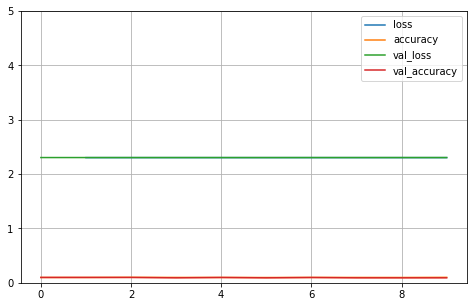

In [82]:

plot_learning_cruves(history)

# bug: 为何loss和精确值一直不变？？？？？？？？？？？？？？？？？？？
# 没解决

In [ ]:
'''
### 关于梯度消失问题
深度模型中可能出现的问题：参数众多，倒只训练不充分
梯度消失问题：首先梯度下降是指，一个数按照其此点最大导数的反方向更新。
对于一个多层次的神经网络来说，比目标函数比较远的但是梯度比较微小的现象。
什么情况会导致？ 一般发生在深度模型中，根据链式法则：符合函数{f(g(x))}
梯度下降的时候我们需要对每一个嵌套的复合函数进行求导再相乘，最后如果求出来的导数小于1，多此相乘就会导致梯度消失。
1.01^99=37.8
0.99^99=0.03

批归一化可以在一定程度上缓解梯度消失~
'''

In [84]:
model.evaluate(x_test, y_test)

10000/10000 [==============================] - 2s 198us/sample - loss: 2.3026 - accuracy: 0.1000


[2.3026404083251952, 0.1]